In [1]:
from IPython.display import HTML
tog='''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''';

def init_esplot():
    plt.close('all');
    fig=plt.figure(figsize=[10, 4]);
    ax=plt.subplot(1,1,1)
    return(ax,fig)
HTML(tog)


In [2]:
%matplotlib inline
execfile('rep_util.py')

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in greater
/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide
/usr/lib/python2.7/dist-packages/nu

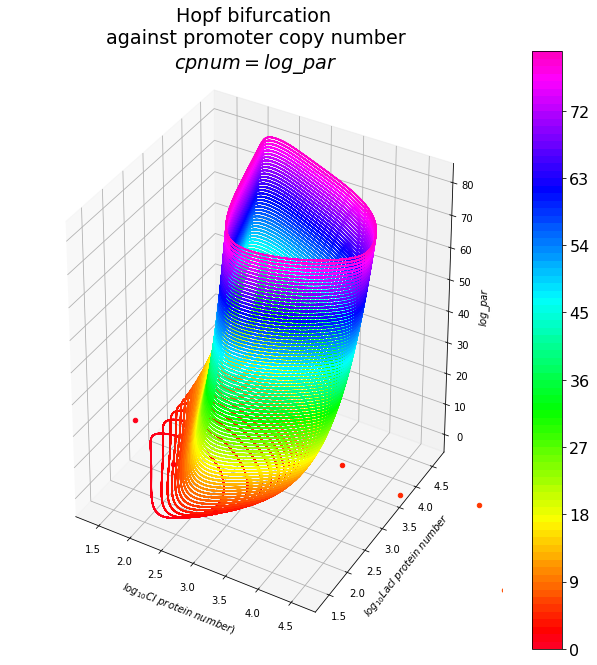

In [3]:
# %matplotlib notebook
##figure1

tl='''Hopf bifurcation 
against promoter copy number
$ cpnum = {log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,11])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,1,1,projection='3d')
# axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(0.,1.,.25);
lst=np.linspace(0,80,81);
siz=len(lst)
######

cmd_onthefly_param='''
#### Temporary parameter/variable change
cpnum=log_par
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
    ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    xs=np.log10(p_CI_obs);
    ys=np.log10(p_LacI_obs)
    zs=[log_par]*len(p_CI_obs)
    axL.plot(xs,ys,zs,color=col,label=lbl)
    axL.scatter(xs[-1],ys[-1],zs[-1],'x',color=col)
    
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000))

# axL.set_yscale('log')
# axL.set_zscale('log')

# axL.xaxis.set_scale('log')
# axL.yaxis.set_scale('log')

axL.set_xlabel('\n$log_{10}CI\ protein\ number)$')
axL.set_ylabel('\n$log_{10}LacI\ protein\  number$')
axL.set_zlabel('\n$log\_par$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axR.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)


# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.axis('tight')
axL.grid(True)
axR.grid(True)

# plt.tight_layout()
plt.savefig('resources/cpnum_0-100C.jpg',dpi=300)

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


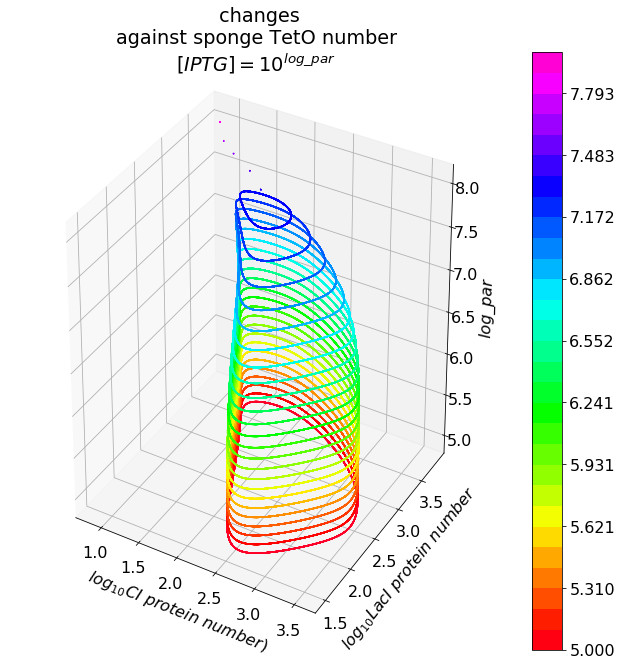

In [7]:
# %matplotlib notebook
##figure2
tl=''' changes
against sponge TetO number
$[IPTG] = 10^{log\_par}$
'''
cmd_onthefly_param='''
#### Temporary parameter/variable change
IPTG=10**log_par
'''

#### passing a list to vary parameter on-the-fly
# lst=np.arange(0.,1.,.25);
lst=np.linspace(5.,8.,30);
siz=len(lst)
######

figname='resources/IPTG_singlevarC.jpg'


tlR='''Amplitude and Period bifurcation
'''
exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,11])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,1,1,projection='3d')
# axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);

    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)



for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
    ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    xs=np.log10(p_CI_obs);
    ys=np.log10(p_LacI_obs)
    zs=[log_par]*len(p_CI_obs)
    axL.plot(xs,ys,zs,color=col,label=lbl)
    axL.scatter(xs[-1],ys[-1],zs[-1],'x',color=col)
    
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000))

# axL.set_yscale('log')
# axL.set_zscale('log')

# axL.xaxis.set_scale('log')
# axL.yaxis.set_scale('log')

axL.set_xlabel('\n$log_{10}CI\ protein\ number)$')
axL.set_ylabel('\n$log_{10}LacI\ protein\  number$')
axL.set_zlabel('\n$log\_par$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axR.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)


# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.axis('tight')
axL.grid(True)
axR.grid(True)

# plt.tight_layout()
plt.savefig(figname,dpi=300)

In [ ]:
# %matplotlib notebook
##figure3
tl=''' changes
against TetO's affinity to TetR
$K_{TetO} = 10^{log\_par}$
'''
cmd_onthefly_param='''
#### Temporary parameter/variable change
K_TetO = 10**log_par;
'''

#### passing a list to vary parameter on-the-fly
# lst=np.arange(0.,1.,.25);
lst=np.linspace(0,4,50);
siz=len(lst)
######


tlR='''Amplitude and Period bifurcation
'''
exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,11])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,1,1,projection='3d')
# axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);

    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)



for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=1,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
    ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    xs=np.log10(p_CI_obs);
    ys=np.log10(p_LacI_obs)
    zs=[log_par]*len(p_CI_obs)
    axL.plot(xs,ys,zs,color=col,label=lbl)
    axL.scatter(xs[-1],ys[-1],zs[-1],'x',color=col)
    
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000))

# axL.set_yscale('log')
# axL.set_zscale('log')

# axL.xaxis.set_scale('log')
# axL.yaxis.set_scale('log')

axL.set_xlabel('\n$log_{10}CI\ protein\ number)$')
axL.set_ylabel('\n$log_{10}LacI\ protein\  number$')
axL.set_zlabel('\n$log\_par$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axR.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)


# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.axis('tight')
axL.grid(True)
axR.grid(True)

# plt.tight_layout()
plt.savefig('resources/K_TetO_C.jpg',dpi=300)

In [ ]:
# %matplotlib notebook
#figur4
tl=''' changes
against sponge TetO number
$cpnum_{TetO} = 10^{log\_par},\ K_{TetO}=5$
'''
cmd_onthefly_param='''
#### Temporary parameter/variable change
K_TetO=5.;
cpnum_TetO=10**log_par;
'''

#### passing a list to vary parameter on-the-fly
# lst=np.arange(0.,1.,.25);
lst=np.linspace(0,4,50);
siz=len(lst)
######

figname='resources/cpnum_TetO_singlevarC.jpg'


tlR='''Amplitude and Period bifurcation
'''
exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,11])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,1,1,projection='3d')
# axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);

    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)



for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
    ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    xs=np.log10(p_CI_obs);
    ys=np.log10(p_LacI_obs)
    zs=[log_par]*len(p_CI_obs)
    axL.plot(xs,ys,zs,color=col,label=lbl)
    axL.scatter(xs[-1],ys[-1],zs[-1],'x',color=col)
    
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000))

# axL.set_yscale('log')
# axL.set_zscale('log')

# axL.xaxis.set_scale('log')
# axL.yaxis.set_scale('log')

axL.set_xlabel('\n$log_{10}CI\ protein\ number)$')
axL.set_ylabel('\n$log_{10}LacI\ protein\  number$')
axL.set_zlabel('\n$log\_par$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axR.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)


# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.axis('tight')
axL.grid(True)
axR.grid(True)

# plt.tight_layout()
plt.savefig(figname,dpi=300)

In [ ]:
# %matplotlib notebook
### figure5
tl='''Infinite period bifurcation 
against protein degradation 
$k_{protein\_degrade} = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,11])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,1,1,projection='3d')
# axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(-6.,-1,80);
siz=len(lst)
######

cmd_onthefly_param='''
#### Temporary parameter/variable change
k_dp=10**(log_par)
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
    ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    xs=np.log10(p_CI_obs);
    ys=np.log10(p_LacI_obs)
    zs=[log_par]*len(p_CI_obs)
    axL.plot(xs,ys,zs,color=col,label=lbl)
    axL.scatter(xs[-1],ys[-1],zs[-1],'x',color=col)
    
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000))

# axL.set_yscale('log')
# axL.set_zscale('log')

# axL.xaxis.set_scale('log')
# axL.yaxis.set_scale('log')

axL.set_xlabel('\n$log_{10}CI\ protein\ number)$')
axL.set_ylabel('\n$log_{10}LacI\ protein\  number$')
axL.set_zlabel('\n$log\_par$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axR.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)


# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.axis('tight')
axL.grid(True)
axR.grid(True)

# plt.tight_layout()
plt.savefig('resources/k_dp_varC.jpg',dpi=300)

/home/tempu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in divide


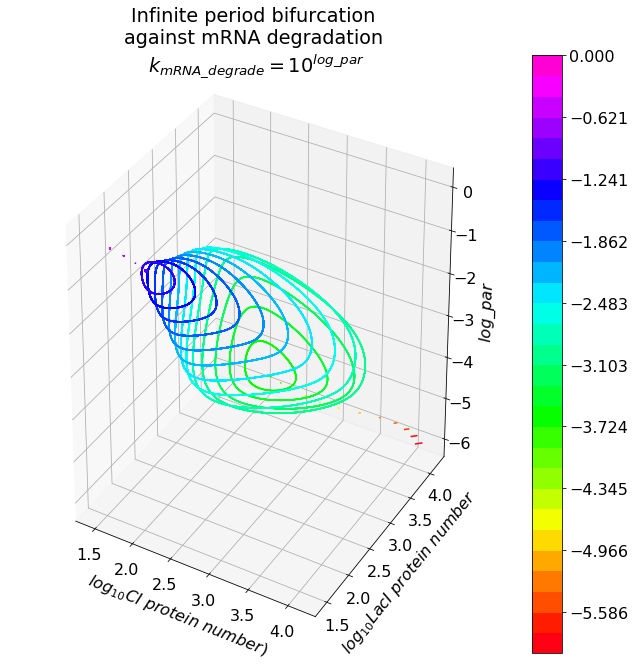

In [8]:
# %matplotlib notebook
### figure6
tl='''Infinite period bifurcation 
against mRNA degradation 
$k_{mRNA\_degrade} = 10^{log\_par}$
'''
tlR='''Amplitude and Period bifurcation
'''

exec(cmd_init_4figures)
plt.close('all')
fig1=plt.figure(figsize=[11,11])
# fig1=plt.figure(figsize=[5.5,5.5])

axL=fig1.add_subplot(1,1,1,projection='3d')
# axR=fig1.add_subplot(1,2,2)
mpl.rcParams.update({'font.size': 16})

axL.set_title(tl);
axR.set_title(tlR);
axR2 = axR.twinx()



#### timescales
t_max=5000.*60.#### set the duration of the simulation
nt=1; #### nt control the sample rate, in unit of fps or Hz. The minimum timescale is set by "step"
t_obs_out=np.linspace(0,t_max,nt*t_max+1) # store obs every 10 seconds
# lc_step = len(t_obs_out); ### lc_step control how much of the ending trajectory is selected for analysis.
lc_step = int(60000*nt); 

exec(cmd_default_setup)
### in case you want to fix m_LacI
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
# exec(cmd_name2dict)
# exec(cmd_precompile_cmd)

#### set the stochastic or deterministic iterative operator (to be used in gill_model() or in odeint() )
dot_gill=precompile(sdot_gill)
# cmd_calcrates=precompile(sdot_det);

## deterministic
cmd_calcrates=precompile(sdot_det);
def dot_det(s,t,param):
    s[np.isnan(s)]=0;
    exec(cmd_unpack_all);
    exec(cmd_calcrates);
    exec(cmd_wrap_all);
    return(sdot)


#### passing a list to vary parameter on-the-fly
# lst=np.arange(1,4.,.5)
lst=np.linspace(-6.,-0,30);
siz=len(lst)
######

cmd_onthefly_param='''
#### Temporary parameter/variable change
k_dm = 10**log_par;
    
'''

for i,log_par in enumerate(lst):
    num_traj=1;
    s_obss=[None]*num_traj;
    tic=timer.time()
#     step=10**log_par;
    for j in range(num_traj):
        exec(cmd_default_param)
        exec(cmd_default_incond) ### use exec(cmd_pack_all+';s0=s00;'+cmd_unpack_all) to overide an initial state from "s00", but be careful.

        exec(cmd_onthefly_param)
        exec(cmd_pack_all)  #### finish temporary change with cmd_pack_all

#         t_obs,s_obs=gill_model(dot_gill,s0); ### run stochastic model
        s_obs=odeint(dot_det,s0,t_obs_out,args=(param,)) #### run deterministic model
        t_obs=t_obs_out[-lc_step:];
        s_obs=s_obs[-lc_step:,:];

        s_obss[j]=(s_obs.tolist());
    s_obss=np.array(s_obss);
    s_obs=s_obss.mean(axis=0)
    s_obs_std=s_obss.std(axis=0,ddof=1);
    s_obs_var=s_obss.var(axis=0,ddof=1);
    s_obs_max=s_obs+s_obs_std
#     print(timer.time()-tic)
    exec(cmd_unpack_allobs)
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    period,amplitude,avg=analyse(p_LacI_obs,debug=0,threshold=50) ### a custom function that detect the period.
#     axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)

    x=max(int(period*nt),5);
    ax3.plot(t_obs[x:-x]/60,np.convolve(s_obs_var[:,4],np.array([1./x]*x),'same')[x:-x],'r',label = 'LacI',color=col)
    xs=np.log10(p_CI_obs);
    ys=np.log10(p_LacI_obs)
    zs=[log_par]*len(p_CI_obs)
    axL.plot(xs,ys,zs,color=col,label=lbl)
    axL.scatter(xs[-1],ys[-1],zs[-1],'x',color=col)
    
    axR.plot(log_par,period/60.,'bx',label=lbl);
    axR2.plot(log_par,amplitude,'ro',label=lbl);
    

# axL.set_xlim(1E-1,1000)
# axL.set_ylim(1E-1,6000))

# axL.set_yscale('log')
# axL.set_zscale('log')

# axL.xaxis.set_scale('log')
# axL.yaxis.set_scale('log')

axL.set_xlabel('\n$log_{10}CI\ protein\ number)$')
axL.set_ylabel('\n$log_{10}LacI\ protein\  number$')
axL.set_zlabel('\n$log\_par$')

cm=plt.get_cmap('gist_rainbow')
Z = [[0,0],[0,0]]
levels = lst;
CS3 = axR.contourf(Z, levels, cmap=cm)
cbar=plt.colorbar(CS3,ax=axL)
# cbar.set_label('$log\_par$', rotation=270)


# plt.colorbar(ax=axL)
# axL.legend()
# axR.set_xscale('log')
# axR.set_yscale('log')
# axR.set_xlim(1,1E4)
# axR.set_ylim(1,1E4)
# axR.legend()
axR.set_xlabel('$log\_par$')
axR.set_ylabel('$Period(min)$',color='b')
axR2.set_ylabel('$Amplitude\ in \ No(LacI)$',color='r')


axL.axis('tight')
axL.grid(True)
axR.grid(True)

# plt.tight_layout()
plt.savefig('resources/k_dm_varC.jpg',dpi=300)